In [11]:
import importlib 
import plot_utils
import domain_objects
import calculator

importlib.reload(plot_utils)
importlib.reload(domain_objects)
importlib.reload(calculator)

<module 'calculator' from 'D:\\coordinating-quantifiers\\v2\\calculator.py'>

In [51]:
import json
import numpy as np
from domain_objects import GameParams, NewAgent
from new_guessing_game import run_simulation, select_speaker, select_hearer, avg_series, random_functions
from calculator import NumericCalculator, QuotientCalculator, load_stimuli_and_calculator
from ipywidgets import widgets, HBox, VBox
from IPython.display import display, clear_output

stimuli_selection_widget = widgets.Select(options=['numeric', 'quotient'], value='quotient', description='Stimuli Type:', disabled=False)
ans_selection_widget = widgets.Checkbox(value=True, description='with ANS')
style = {'description_width': 'initial'}
population_size_selection_widget = widgets.IntSlider(
    value=10,
    min=2,
    max=20,
    step=2,
    description='Population size',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=style
)
steps_selection_widget = widgets.IntSlider(
    value=500,
    min=100,
    max=5000,
    step=100,
    description='Number of steps',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=style
)

run_simulation_button = widgets.Button(
    description='Run Simulation',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='play'
)

simulation_result = {}
output = widgets.Output()

def run_simulation_action(obj):
    run_simulation_button.disabled=True
    run_simulation_button.button_style='warning'
    run_simulation_button.icon='hourglass'
    
    population_size=population_size_selection_widget.value
    stimulus=stimuli_selection_widget.value
    steps=steps_selection_widget.value
    with_ans=ans_selection_widget.value
    
    max_num=100
    discriminative_threshold=0.95
    discriminative_history_length=50
    delta_inc=0.2
    delta_dec=0.2
    delta_inh=0.2
    alpha=0.01
    super_alpha=0.001
    beta=0.2
    runs=1
    guessing_game_2=False
    seed=0
    
    params = GameParams(population_size=population_size,
                   stimulus=stimulus,
                   max_num=max_num,
                   discriminative_threshold=discriminative_threshold,
                   discriminative_history_length=discriminative_threshold,
                   delta_inc=delta_inc,
                   delta_dec=delta_dec,
                   delta_inh=delta_inh,
                   alpha=alpha,
                   super_alpha=super_alpha,
                   beta=beta,
                   steps=steps,
                   runs=runs,
                   guessing_game_2=guessing_game_2,
                   seed=seed)
    
    with output:
        clear_output()
        print('Running simulation with params:', vars(params))
    
        shuffle_list, flip_a_coin, pick_element = next(random_functions(seed=params.seed))
        stimuli, calculator = load_stimuli_and_calculator(params.stimulus)

        population = run_simulation(stimuli, calculator, params, shuffle_list, flip_a_coin, pick_element)

        run_simulation_button.button_style='success'
        run_simulation_button.disabled=False  
        run_simulation_button.icon='play'

        simulation_result['stimuli'] = stimuli
        simulation_result['params'] = params
        simulation_result['population'] = population
        simulation_result['calculator'] = calculator

run_simulation_button.on_click(run_simulation_action)
control_pane = HBox([stimuli_selection_widget, ans_selection_widget, VBox([population_size_selection_widget, steps_selection_widget])])

display(VBox([run_simulation_button, widgets.HTML(value="<hr/>"), control_pane]), output)

Output()

In [47]:
population = simulation_result['population']
stimuli = simulation_result['stimuli']
calculator = simulation_result['calculator']

windowed_communicative_success1 = np.array([avg_series(a.get_communicative_success1()) for a in population])*100
windowed_communicative_success2 = [avg_series(a.get_communicative_success2()) for a in population]
windowed_discriminative_success = np.array([avg_series(a.get_discriminative_success()) for a in population])*100


In [48]:
averaged_windowed_communicative_success1 = np.mean(windowed_communicative_success1, axis=0)
averaged_windowed_discriminative_success = np.mean(windowed_discriminative_success, axis=0)

# Analysis & Visualizations

## Single Agent Analysis

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from plot_utils import bokeh_plot_category, plot_category


In [50]:
agent = population[0]
meanings = agent.compute_word_meanings(stimuli)   

word, activations = list(meanings.items())[2]
stimuli_meaning = np.array(stimuli)[activations]
most_connected_category = agent.get_most_connected_category(word)
most_connected_category_pdf = most_connected_category.discretized_distribution(calculator)

stimuli_meaning = [float(v) for v in stimuli_meaning]
figure = plot_utils.bokeh_plot_category(most_connected_category, calculator.domain(), most_connected_category_pdf, stimuli_meaning)

output_notebook()
show(figure)

Loading BokehJS ...

In [24]:
agent = population[0]
word2pragmatic_meaning = agent.compute_word_pragmatic_meanings(stimuli)   

word, pragmatic_meaning = list(meanings.items())[0]

most_connected_category = agent.get_most_connected_category(word)
most_connected_category_pdf = most_connected_category.discretized_distribution(calculator)

stimuli_meaning = [float(v) for v in pragmatic_meaning]
figure = plot_utils.bokeh_plot_category(most_connected_category, calculator.domain(), most_connected_category_pdf, stimuli_meaning)

output_notebook()
show(figure)

Loading BokehJS ...

In [25]:
agent = population[3]
recreated_agent_snapshots = NewAgent.recreate_from_history(agent_id=agent.agent_id, calculator=calculator, game_params=params, updates_history=agent.updates_history)

recreating agent 7 by updates: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4100/4100 [00:01<00:00, 2914.37it/s]


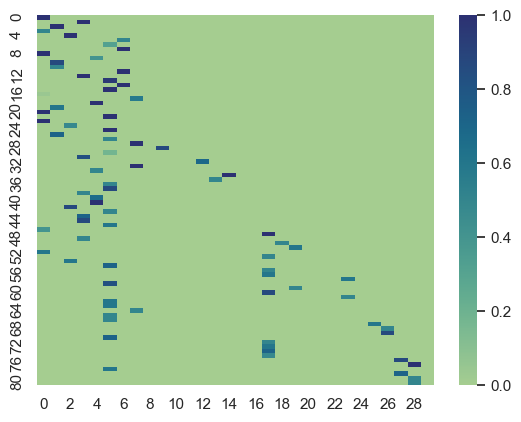

In [26]:
step, snapshot = recreated_agent_snapshots[10]
agent_dict = NewAgent.to_dict(snapshot)
lxc = np.array(agent_dict['lxc'])

sns.set()
ax = sns.heatmap(lxc, vmin=0, vmax=1, cmap="crest")
plt.show()

## Population Statistics

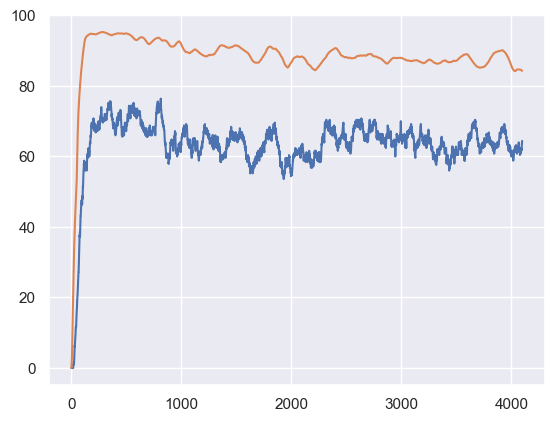

In [27]:
plt.plot(range(len(averaged_windowed_communicative_success1)), averaged_windowed_communicative_success1)
plt.plot(range(len(averaged_windowed_discriminative_success)), averaged_windowed_discriminative_success)

plt.show()


In [28]:
population_snapshots = [NewAgent.recreate_from_history(agent_id=a.agent_id, calculator=calculator, game_params=params, updates_history=a.updates_history, snapshot_rate=100)for a in population]

recreating agent 1 by updates: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4100/4100 [00:01<00:00, 3838.16it/s]


In [29]:
agent = population[3]
categories = [agent.get_most_responsive_category(s) for s in stimuli]
active_words = [agent.get_most_connected_word(c) for c in categories]
active_words = [w for w in active_words if w is not None]
set(active_words)

{11, 17, 201, 31, 421, 45, 572}

In [46]:
i = 10
ith_population_snapshot = [agent_snapshots[i] for agent_snapshots in population_snapshots]

In [47]:
len(set([w for step, a in ith_population_snapshot for w in a.get_active_words(stimuli)]))/len(population)

2.9

In [32]:
#population_active_lexicon = [[snap.get_active_words(stimuli) for step, snap in history[1:]] for history in population_snapshots]

population_active_lexicon = [[snap.get_words() for step, snap in history[1:]] for history in population_snapshots]
snapshot_steps = [step for step, h in population_snapshots[0]]

In [33]:
population_active_lexiconz = [0] + [len(list(set(word for active_lexicon in snap for word in active_lexicon))) for snap in zip(*population_active_lexicon)]

In [39]:
active = set([w for lex in population_active_lexicon[-1] for w in lex])
acit

{0,
 1,
 10,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 108,
 109,
 11,
 110,
 111,
 113,
 114,
 115,
 116,
 12,
 123,
 129,
 13,
 130,
 131,
 136,
 137,
 138,
 139,
 14,
 140,
 144,
 145,
 146,
 15,
 150,
 151,
 157,
 16,
 160,
 161,
 165,
 166,
 167,
 168,
 169,
 17,
 173,
 176,
 177,
 179,
 18,
 180,
 181,
 182,
 184,
 185,
 191,
 194,
 195,
 198,
 201,
 202,
 208,
 210,
 212,
 213,
 215,
 217,
 218,
 22,
 220,
 221,
 224,
 225,
 227,
 230,
 231,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 24,
 244,
 245,
 246,
 25,
 250,
 251,
 252,
 255,
 256,
 259,
 26,
 261,
 262,
 265,
 266,
 267,
 269,
 27,
 270,
 271,
 273,
 274,
 277,
 278,
 28,
 282,
 283,
 284,
 286,
 287,
 288,
 289,
 29,
 290,
 291,
 294,
 299,
 3,
 300,
 303,
 306,
 308,
 309,
 31,
 311,
 313,
 314,
 32,
 322,
 325,
 331,
 332,
 333,
 336,
 340,
 342,
 343,
 345,
 346,
 35,
 350,
 352,
 353,
 365,
 366,
 367,
 368,
 370,
 371,
 373,
 374,
 376,
 378,
 38,
 380,
 381,
 383,
 385,
 387,
 39,
 391,
 396,
 398,
 40,
 400,
 4

In [35]:
from bokeh.plotting import figure

fig = figure(title='Success Rate', x_axis_label='Steps')
steps_range = [*range(steps)]
fig.line(steps_range, averaged_windowed_discriminative_success, legend_label='discriminative success', line_width=.5, color='red')
fig.line(steps_range, averaged_windowed_communicative_success1, legend_label='communicative success 1', line_width=.5, color='green')
fig.line(snapshot_steps, population_active_lexiconz, legend_label='lexicon size', line_width=.5, color='blue')

output_notebook()
show(fig)


Loading BokehJS ...